In [64]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.tsa.seasonal import STL
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator, awesome_oscillator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
import warnings
warnings.filterwarnings('ignore')

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [65]:
def plot_ohlc(df):
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Ohlc(x=df.index,
                          open=df.Open,
                          high=df.High,
                          low=df.Low,
                          close=df.Close,
                          name='Price'), row=1, col=1)

    fig.add_trace(go.Scatter(x=df.index, y=df.Volume, name='Volume'), row=2, col=1)

    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.show()

def plot_decomposed_close_data(df):
    data = azn_df[['Close']].copy()
    res = STL(data, period=365).fit()
    fig = res.plot()
    fig.set_size_inches(20, 8)
    
def plot_moving_averages(df):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=df.EMA_9, name='EMA 9'))
    fig.add_trace(go.Scatter(x=df.index, y=df.SMA_5, name='SMA 5'))
    fig.add_trace(go.Scatter(x=df.index, y=df.SMA_10, name='SMA 10'))
    fig.add_trace(go.Scatter(x=df.index, y=df.SMA_15, name='SMA 15'))
    fig.add_trace(go.Scatter(x=df.index, y=df.SMA_30, name='SMA 30'))
    fig.add_trace(go.Scatter(x=df.index, y=df.Close, name='Close', opacity=0.2))
    fig.show()
    
def plot_RSI(df):
    fig = go.Figure(go.Scatter(x=df.index, y=df.RSI, name='RSI'))
    fig.show()
    
def plot_MACD(df):
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Scatter(x=df.index, y=df['MACD'], name='MACD'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=df['MACD Signal'], name='Signal line'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=df.Close, name='Close'), row=2, col=1)
    fig.show()
    
def plot_train_test_data(train_df, valid_df, test_df):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
    fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
    fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
    fig.show()
    
def plot_predictions(predicted_prices, df, column):
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Scatter(x=df.index, y=df[column],
                             name='Truth',
                             marker_color='LightSkyBlue'), row=1, col=1)

    fig.add_trace(go.Scatter(x=predicted_prices.index,
                             y=predicted_prices[column],
                             name='Prediction',
                             marker_color='MediumPurple'), row=1, col=1)

    fig.show()
    
def plot_high_low_predictions(predicted_prices, df):
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Scatter(x=df.index, y=df.High,
                             name='Truth',
                             marker_color='LightSkyBlue'), row=1, col=1)

    fig.add_trace(go.Scatter(x=predicted_prices.index,
                             y=predicted_prices.High,
                             name='Prediction',
                             marker_color='MediumPurple'), row=1, col=1)

    fig.show()
    
def get_moving_averages(df):
    df_sma = SMAIndicator(close=df['Close'], window=5)
    df['SMA_5'] = df_sma.sma_indicator()
    df_sma = SMAIndicator(close=df['Close'], window=10)
    df['SMA_10'] = df_sma.sma_indicator()
    df_sma = SMAIndicator(close=df['Close'], window=15)
    df['SMA_15'] = df_sma.sma_indicator()
    df_sma = SMAIndicator(close=df['Close'], window=30)
    df['SMA_30'] = df_sma.sma_indicator()
    df_ema = EMAIndicator(close=df['Close'], window=9)
    df['EMA_9'] = df_ema.ema_indicator()
    df.dropna(inplace=True)
    
def get_RSI(df):
    df_rsi = RSIIndicator(close=df['Close'], window=14)
    df['RSI'] = df_rsi.rsi()
    df.dropna(inplace=True)
    
def get_MACD(df):
    macd = MACD(close=df['Close'])
    df['MACD'] = macd.macd()
    df['MACD Signal'] = macd.macd_signal()
    df.dropna(inplace=True)

In [66]:
start = dt.datetime(2010,1,1)
end = dt.datetime.now()
tickers = ['PFE', 'MRNA', 'JNJ', 'AZN']

filenames = []

for ticker in tickers:
    if ticker == 'MRNA':
        df = yf.download(ticker, dt.datetime(2018,12,7), end)
    else:
        df = yf.download(ticker, start, end)
    filename = f'{ticker}_stock_prices.csv'
    filenames.append(filename)
    df.to_csv(filename)
    
for filename in filenames:
    if filename.startswith('AZN'):
        azn_df = pd.read_csv('AZN_stock_prices.csv', index_col='Date', parse_dates=True)
    elif filename.startswith('MRNA'):
        mrna_df = pd.read_csv('MRNA_stock_prices.csv', index_col='Date', parse_dates=True)
    elif filename.startswith('JNJ'):
        jnj_df = pd.read_csv('JNJ_stock_prices.csv', index_col='Date', parse_dates=True)
    else:
        pfe_df = pd.read_csv('PFE_stock_prices.csv', index_col='Date', parse_dates=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [67]:
pfe_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,17.333965,17.969639,17.305504,17.960152,11.590302,54898644
2010-01-05,17.950665,17.960152,17.599621,17.703985,11.424991,45714931
2010-01-06,17.703985,17.846300,17.561670,17.647058,11.388254,43640975
2010-01-07,17.685009,17.713472,17.514231,17.580645,11.345395,41557112
2010-01-08,17.666035,17.751423,17.571157,17.722960,11.437235,32049716


In [68]:
get_moving_averages(pfe_df)
pfe_df.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_5,SMA_10,SMA_15,SMA_30,EMA_9
Date,,,,,,,,,,,
2010-02-16,17.039848,17.153700,16.707781,16.812143,10.951913,66699017,16.889943,17.144213,17.366224,17.730234,17.076368
2010-02-17,16.935484,16.944971,16.631880,16.764706,10.921010,61399821,16.850095,16.995256,17.296015,17.690386,17.014036
2010-02-18,16.774195,16.840607,16.650854,16.821632,10.958093,60202899,16.848197,16.910816,17.215686,17.660974,16.975555
2010-02-19,16.907021,17.172676,16.821632,17.068312,11.118790,53393321,16.870968,16.907021,17.175206,17.641682,16.994106
2010-02-22,17.058825,17.220114,16.869070,17.030361,11.094068,61134003,16.899431,16.906072,17.130297,17.623340,17.001357


In [69]:
get_RSI(pfe_df)
pfe_df.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_5,SMA_10,SMA_15,SMA_30,EMA_9,RSI
Date,,,,,,,,,,,,
2010-03-05,16.489565,16.603416,16.347248,16.584440,10.803580,68202654,16.599620,16.712524,16.765339,17.138204,16.664820,42.568580
2010-03-08,16.688805,16.698292,16.385199,16.461102,10.723234,51370695,16.523719,16.655598,16.736876,17.087287,16.624076,38.350116
2010-03-09,16.385199,16.432638,16.271347,16.347248,10.649069,57489271,16.453511,16.613852,16.705883,17.036053,16.568710,34.910913
2010-03-10,16.328274,16.461102,16.233397,16.271347,10.599622,59341465,16.421252,16.551233,16.672992,16.984504,16.509238,32.799174
2010-03-11,16.242884,16.432638,16.223909,16.404175,10.686151,51448270,16.413662,16.513283,16.645161,16.930424,16.488225,39.676099


In [70]:
get_MACD(pfe_df)
pfe_df.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_5,SMA_10,SMA_15,SMA_30,EMA_9,RSI,MACD,MACD Signal
Date,,,,,,,,,,,,,,
2010-04-22,15.654649,15.711575,15.493359,15.635674,10.185527,73482877,15.831120,16.054080,16.088552,16.227704,15.941996,29.941581,-0.157286,-0.100417
2010-04-23,15.588235,16.138519,15.559772,16.043644,10.451290,103613470,15.851993,16.021822,16.077799,16.215686,15.962326,46.136559,-0.142201,-0.108774
2010-04-26,15.996205,16.100569,15.844402,15.958254,10.395664,87980858,15.857685,15.977230,16.072739,16.207464,15.961511,43.851643,-0.135574,-0.114134
2010-04-27,15.853890,15.986717,15.559772,15.616698,10.173165,96488746,15.800759,15.908919,16.041113,16.182163,15.892549,36.141389,-0.156083,-0.122524
2010-04-28,15.626186,15.787476,15.550285,15.683112,10.216431,63932478,15.787477,15.857685,16.006958,16.159077,15.850661,38.409069,-0.165075,-0.131034


In [71]:
pfe_df['Close'] = pfe_df['Close'].shift(-1)
pfe_df.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_5,SMA_10,SMA_15,SMA_30,EMA_9,RSI,MACD,MACD Signal
Date,,,,,,,,,,,,,,
2010-04-22,15.654649,15.711575,15.493359,16.043644,10.185527,73482877,15.831120,16.054080,16.088552,16.227704,15.941996,29.941581,-0.157286,-0.100417
2010-04-23,15.588235,16.138519,15.559772,15.958254,10.451290,103613470,15.851993,16.021822,16.077799,16.215686,15.962326,46.136559,-0.142201,-0.108774
2010-04-26,15.996205,16.100569,15.844402,15.616698,10.395664,87980858,15.857685,15.977230,16.072739,16.207464,15.961511,43.851643,-0.135574,-0.114134
2010-04-27,15.853890,15.986717,15.559772,15.683112,10.173165,96488746,15.800759,15.908919,16.041113,16.182163,15.892549,36.141389,-0.156083,-0.122524
2010-04-28,15.626186,15.787476,15.550285,15.996205,10.216431,63932478,15.787477,15.857685,16.006958,16.159077,15.850661,38.409069,-0.165075,-0.131034


In [72]:
pfe_df = pfe_df[:-1]
pfe_df.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA_5,SMA_10,SMA_15,SMA_30,EMA_9,RSI,MACD,MACD Signal
Date,,,,,,,,,,,,,,
2021-08-26,47.700001,48.160000,47.299999,46.599998,47.380001,29029300,48.384000,48.784,48.042000,45.306667,48.131092,56.155223,1.645810,1.907558
2021-08-27,47.369999,47.500000,46.529999,46.759998,46.599998,32874400,47.960000,48.596,48.144000,45.515000,47.824873,52.118059,1.420385,1.810123
2021-08-30,46.200001,47.160000,46.160000,46.070000,46.759998,25774400,47.325999,48.381,48.196000,45.735333,47.611898,52.866613,1.240347,1.696168
2021-08-31,46.720001,47.139999,45.930000,46.040001,46.070000,34547800,46.863999,47.946,48.054667,45.902667,47.303519,49.288067,1.030114,1.562957
2021-09-01,46.189999,46.259998,45.419998,46.840000,46.040001,32900100,46.570000,47.619,48.036667,46.070000,47.050815,49.132352,0.851269,1.420620


In [73]:
pfe_df.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_5,SMA_10,SMA_15,SMA_30,EMA_9,RSI,MACD,MACD Signal
Date,,,,,,,,,,,,,,
2010-04-22,15.654649,15.711575,15.493359,16.043644,10.185527,73482877,15.831120,16.054080,16.088552,16.227704,15.941996,29.941581,-0.157286,-0.100417
2010-04-23,15.588235,16.138519,15.559772,15.958254,10.451290,103613470,15.851993,16.021822,16.077799,16.215686,15.962326,46.136559,-0.142201,-0.108774
2010-04-26,15.996205,16.100569,15.844402,15.616698,10.395664,87980858,15.857685,15.977230,16.072739,16.207464,15.961511,43.851643,-0.135574,-0.114134
2010-04-27,15.853890,15.986717,15.559772,15.683112,10.173165,96488746,15.800759,15.908919,16.041113,16.182163,15.892549,36.141389,-0.156083,-0.122524
2010-04-28,15.626186,15.787476,15.550285,15.996205,10.216431,63932478,15.787477,15.857685,16.006958,16.159077,15.850661,38.409069,-0.165075,-0.131034


In [74]:
df_train_2012 = pfe_df.loc['2010-04-21':'2012-04-21', :]
df_train_2012.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_5,SMA_10,SMA_15,SMA_30,EMA_9,RSI,MACD,MACD Signal
Date,,,,,,,,,,,,,,
2010-04-22,15.654649,15.711575,15.493359,16.043644,10.185527,73482877,15.831120,16.054080,16.088552,16.227704,15.941996,29.941581,-0.157286,-0.100417
2010-04-23,15.588235,16.138519,15.559772,15.958254,10.451290,103613470,15.851993,16.021822,16.077799,16.215686,15.962326,46.136559,-0.142201,-0.108774
2010-04-26,15.996205,16.100569,15.844402,15.616698,10.395664,87980858,15.857685,15.977230,16.072739,16.207464,15.961511,43.851643,-0.135574,-0.114134
2010-04-27,15.853890,15.986717,15.559772,15.683112,10.173165,96488746,15.800759,15.908919,16.041113,16.182163,15.892549,36.141389,-0.156083,-0.122524
2010-04-28,15.626186,15.787476,15.550285,15.996205,10.216431,63932478,15.787477,15.857685,16.006958,16.159077,15.850661,38.409069,-0.165075,-0.131034


In [75]:
df_train_2012.shape

(505, 14)

In [76]:
df_test_2014 = pfe_df.loc['2012-04-21':'2013-10-21', :]
df_test_2014.shape

(377, 14)

In [77]:
x_train = df_train_2012.drop('Close', axis=1)
y_train = df_train_2012[['Close']]
x_test = df_test_2014.drop('Close', axis=1)
y_test = df_test_2014[['Close']]

In [78]:
# Preprocessing

scaler = MinMaxScaler()

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [79]:
### Trying LSTM model

x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

model_1 = Sequential()

number_units = 50
dropout_fraction = 0.1

# Layer 1
model_1.add(LSTM(
    units = number_units,
    return_sequences = True,
    input_shape = (x_train.shape[1],1))
         )
model_1.add(Dropout(dropout_fraction))

# Layer 2
model_1.add(LSTM(
    units = number_units,
    return_sequences = True,
        ))
model_1.add(Dropout(dropout_fraction))

# Layer 3
model_1.add(LSTM(
    units = number_units,
    return_sequences = False,
        ))
model_1.add(Dropout(dropout_fraction))

model_1.add(Dense(1))

In [80]:
model_1.compile(optimizer="adam", loss="mean_squared_error")
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 13, 50)            10400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 13, 50)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 13, 50)            20200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 13, 50)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [81]:
epochs = 50
batch_size = 10
model_1.fit(x_train, y_train, epochs=epochs, shuffle=False, batch_size=batch_size, verbose=1)

Epoch 1/50
51/51 [==============================] - 4s 13ms/step - loss: 0.0152
Epoch 2/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0428
Epoch 3/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0519
Epoch 4/50
51/51 [==============================] - 1s 12ms/step - loss: 0.0111
Epoch 5/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0044
Epoch 6/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0035
Epoch 7/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0035
Epoch 8/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0035
Epoch 9/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0038
Epoch 10/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0059
Epoch 11/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0100
Epoch 12/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0096
Epoch 13/50
51/51 [==================

In [82]:
model_1.evaluate(x_test, y_test)

12/12 [==============================] - 1s 5ms/step - loss: 0.2082


0.2082161158323288

In [83]:
y_pred = model_1.predict(x_test)
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 0.20821612482313995


In [84]:
df_test_2014.shape

(377, 14)

In [85]:
df_test_2014['Predicted Close'] = scaler.inverse_transform(y_pred.reshape(-1,1))

In [86]:
df_test_2014.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_5,SMA_10,SMA_15,SMA_30,EMA_9,RSI,MACD,MACD Signal,Predicted Close
Date,,,,,,,,,,,,,,,
2012-04-23,21.223909,21.375711,21.176472,21.470589,15.034741,25905107,21.259962,21.037002,21.103099,21.002846,21.155527,57.300762,0.130759,0.127988,21.081200
2012-04-24,21.242884,21.631880,21.204933,21.707781,15.202699,37466116,21.320683,21.097723,21.105629,21.037318,21.218540,62.541364,0.148543,0.132099,21.194012
2012-04-25,21.603416,21.802656,21.574953,21.878557,15.370641,32351160,21.402277,21.185958,21.127135,21.064832,21.316388,66.914415,0.179704,0.141620,21.278698
2012-04-26,21.698292,21.925997,21.650854,21.897533,15.491565,116828100,21.538900,21.294118,21.169513,21.100569,21.428822,69.660727,0.215693,0.156434,21.588129
2012-04-27,21.954458,22.106262,21.802656,21.726755,15.504995,94141699,21.637571,21.410816,21.216319,21.137571,21.522564,69.959121,0.242946,0.173737,21.572803


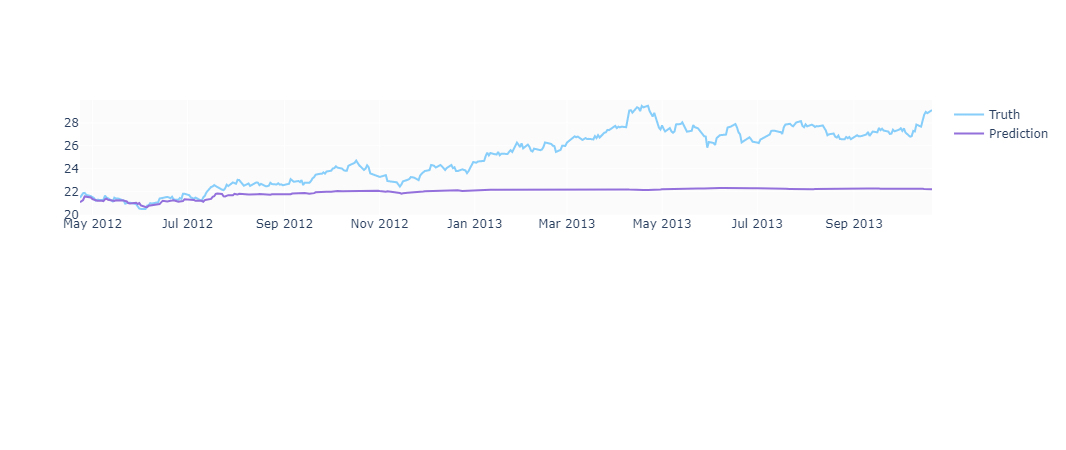

In [87]:
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df_test_2014.index, y=df_test_2014['Close'],
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=df_test_2014.index,
                         y=df_test_2014['Predicted Close'],
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.show()

#################

In [88]:
df_train_2015 = pfe_df.loc['2013-10-21':'2015-10-21', :]
df_train_2015.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA_5,SMA_10,SMA_15,SMA_30,EMA_9,RSI,MACD,MACD Signal
Date,,,,,,,,,,,,,,
2015-10-15,31.242884,32.390892,31.242884,32.647060,25.819635,27807787,31.605313,31.526566,30.946869,30.929791,31.468665,60.183162,0.145124,-0.032774
2015-10-16,32.590134,32.675522,32.258064,32.732449,26.069654,20238908,31.827325,31.652752,31.106262,31.009488,31.704344,62.330567,0.237320,0.021245
2015-10-19,32.647060,32.770397,32.343452,32.258064,26.137833,16632963,32.070209,31.749526,31.339026,31.108476,31.909965,62.917945,0.313660,0.079728
2015-10-20,32.874763,32.912712,32.030361,31.745731,25.759022,18436146,32.263757,31.864327,31.527514,31.154965,31.979585,57.549065,0.332054,0.130193
2015-10-21,32.419353,32.580647,31.337761,31.622391,25.349915,34867585,32.343454,31.880456,31.657179,31.202404,31.932814,52.353187,0.301811,0.164517


In [89]:
df_test_2017 = pfe_df.loc['2015-10-21':'2017-01-21', :]
df_test_2017.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_5,SMA_10,SMA_15,SMA_30,EMA_9,RSI,MACD,MACD Signal
Date,,,,,,,,,,,,,,
2015-10-21,32.419353,32.580647,31.337761,31.622391,25.349915,34867585,32.343454,31.880456,31.657179,31.202404,31.932814,52.353187,0.301811,0.164517
2015-10-22,31.859583,31.916510,31.204933,32.305504,25.251415,43599764,32.201139,31.903226,31.751423,31.224858,31.870730,51.155748,0.264838,0.184581
2015-10-23,31.745731,32.590134,31.527514,32.409866,25.796906,29021468,32.132828,31.980076,31.812777,31.259013,31.957684,57.019233,0.287346,0.205134
2015-10-26,32.258064,32.609108,32.096775,33.197342,25.880239,24548819,32.068311,32.069260,31.855788,31.304870,32.048121,57.851685,0.310031,0.226113
2015-10-27,33.216320,33.633778,32.874763,33.633778,26.509068,42242001,32.256167,32.259962,31.994940,31.362429,32.277965,63.583139,0.387089,0.258308


In [90]:
x_train = df_train_2015.drop('Close', axis=1)
y_train = df_train_2015[['Close']]
x_test = df_test_2017.drop('Close', axis=1)
y_test = df_test_2017[['Close']]

In [91]:
# Preprocessing

scaler = MinMaxScaler()

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [92]:
x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [93]:
epochs = 50
batch_size = 10
model_1.fit(x_train, y_train, epochs=epochs, shuffle=False, batch_size=batch_size, verbose=1)

Epoch 1/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0048
Epoch 2/50
51/51 [==============================] - 1s 12ms/step - loss: 0.0043
Epoch 3/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0045
Epoch 4/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0046
Epoch 5/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0044
Epoch 6/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0045
Epoch 7/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0048
Epoch 8/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0048
Epoch 9/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0054
Epoch 10/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0052
Epoch 11/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0057
Epoch 12/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0060
Epoch 13/50
51/51 [==================

In [94]:
model_1.evaluate(x_test, y_test)

10/10 [==============================] - 0s 5ms/step - loss: 0.0091


0.009074191562831402

In [95]:
y_pred = model_1.predict(x_test)
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 0.009074191848379654


In [96]:
df_test_2017['Predicted Close'] = scaler.inverse_transform(y_pred.reshape(-1,1))

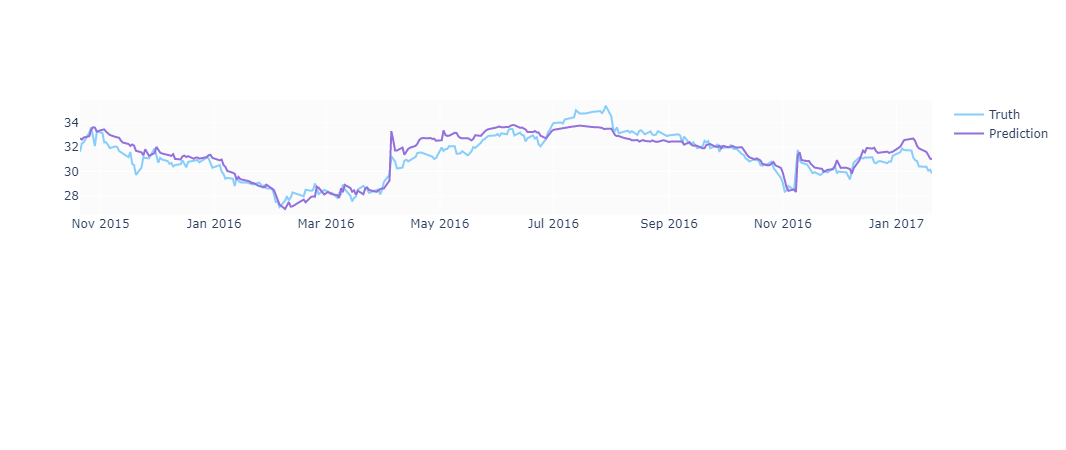

In [97]:
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df_test_2017.index, y=df_test_2017['Close'],
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=df_test_2017.index,
                         y=df_test_2017['Predicted Close'],
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.show()

In [98]:
############ Creating next rolling testing data
df_train_2019 = pfe_df.loc['2017-01-27':'2020-06-27', :]
df_train_2019.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA_5,SMA_10,SMA_15,SMA_30,EMA_9,RSI,MACD,MACD Signal
Date,,,,,,,,,,,,,,
2020-06-22,31.622391,31.650854,31.223909,31.091082,29.893572,23332503,31.637571,32.188805,32.901961,34.258065,32.119139,33.216828,-0.949409,-0.697798
2020-06-23,31.499050,31.546490,31.062618,30.540796,29.586601,37690408,31.518027,31.862429,32.687540,34.089500,31.913527,31.518809,-0.986462,-0.755531
2020-06-24,31.034157,31.053131,30.360531,30.664137,29.062944,30817695,31.258065,31.508539,32.436433,33.925996,31.638981,28.812940,-1.048147,-0.814054
2020-06-25,30.464895,30.721064,30.199242,30.398481,29.180315,27418651,31.083492,31.415560,32.203036,33.776407,31.444012,30.258158,-1.074692,-0.866182
2020-06-26,30.597723,30.626186,29.990513,30.967743,28.927515,42153992,30.821632,31.253321,31.953194,33.590449,31.234906,28.897378,-1.104435,-0.913832


In [99]:
df_test_2019 = pfe_df.loc['2020-06-28':, :]
df_test_2019.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA_5,SMA_10,SMA_15,SMA_30,EMA_9,RSI,MACD,MACD Signal
Date,,,,,,,,,,,,,,
2021-08-26,47.700001,48.160000,47.299999,46.599998,47.380001,29029300,48.384000,48.784,48.042000,45.306667,48.131092,56.155223,1.645810,1.907558
2021-08-27,47.369999,47.500000,46.529999,46.759998,46.599998,32874400,47.960000,48.596,48.144000,45.515000,47.824873,52.118059,1.420385,1.810123
2021-08-30,46.200001,47.160000,46.160000,46.070000,46.759998,25774400,47.325999,48.381,48.196000,45.735333,47.611898,52.866613,1.240347,1.696168
2021-08-31,46.720001,47.139999,45.930000,46.040001,46.070000,34547800,46.863999,47.946,48.054667,45.902667,47.303519,49.288067,1.030114,1.562957
2021-09-01,46.189999,46.259998,45.419998,46.840000,46.040001,32900100,46.570000,47.619,48.036667,46.070000,47.050815,49.132352,0.851269,1.420620


In [100]:
x_train = df_train_2019.drop('Close', axis=1)
y_train = df_train_2019[['Close']]
x_test = df_test_2019.drop('Close', axis=1)
y_test = df_test_2019[['Close']]

In [101]:
scaler = MinMaxScaler()

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [102]:
x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [103]:
epochs = 50
batch_size = 10
model_1.fit(x_train, y_train, epochs=epochs, shuffle=False, batch_size=batch_size, verbose=1)

Epoch 1/50
86/86 [==============================] - 3s 9ms/step - loss: 0.0035
Epoch 2/50
86/86 [==============================] - 1s 10ms/step - loss: 0.0030
Epoch 3/50
86/86 [==============================] - 1s 10ms/step - loss: 0.0035 ETA: 0s - lo
Epoch 4/50
86/86 [==============================] - 1s 10ms/step - loss: 0.0035 ETA: 0s -
Epoch 5/50
86/86 [==============================] - 1s 10ms/step - loss: 0.0039
Epoch 6/50
86/86 [==============================] - 1s 11ms/step - loss: 0.0041
Epoch 7/50
86/86 [==============================] - 1s 10ms/step - loss: 0.0042
Epoch 8/50
86/86 [==============================] - 1s 10ms/step - loss: 0.0047
Epoch 9/50
86/86 [==============================] - 1s 10ms/step - loss: 0.0053
Epoch 10/50
86/86 [==============================] - 1s 10ms/step - loss: 0.0054
Epoch 11/50
86/86 [==============================] - 1s 10ms/step - loss: 0.0056
Epoch 12/50
86/86 [==============================] - 1s 9ms/step - loss: 0.0058
Epoch 13/50
86/8

In [104]:
model_1.evaluate(x_test, y_test)

10/10 [==============================] - 0s 5ms/step - loss: 0.0228


0.02276427298784256

In [105]:
y_pred = model_1.predict(x_test)
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 0.02276427166900243


In [106]:
df_test_2019['Predicted Close'] = scaler.inverse_transform(y_pred.reshape(-1,1))

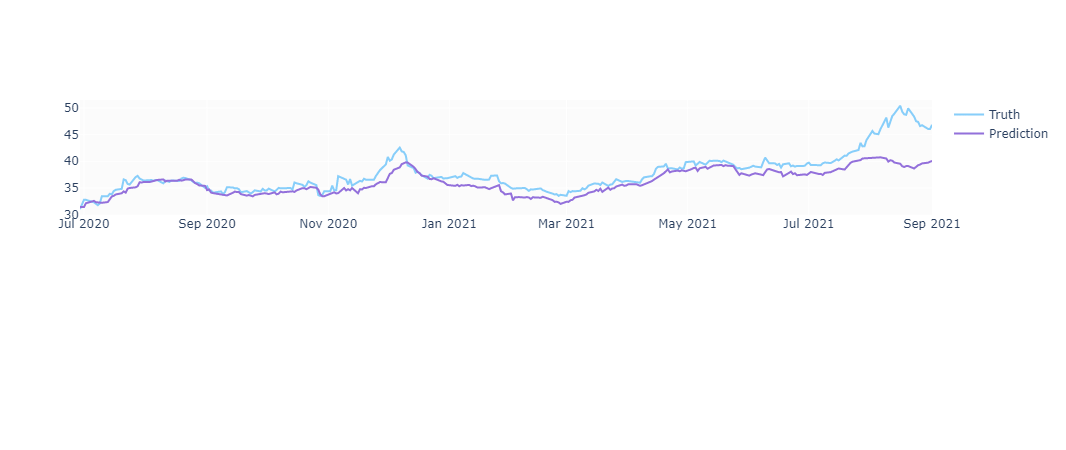

In [107]:
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df_test_2019.index, y=df_test_2019['Close'],
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=df_test_2019.index,
                         y=df_test_2019['Predicted Close'],
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.show()

In [108]:
df = pd.read_csv('PFE_stock_prices.csv', index_col='Date', parse_dates=True)
get_moving_averages(df)
get_RSI(df)
get_MACD(df)
inp = df[-1:].drop('Close', axis=1)
inp

,Open,High,Low,Adj Close,Volume,SMA_5,SMA_10,SMA_15,SMA_30,EMA_9,RSI,MACD,MACD Signal
Date,,,,,,,,,,,,,
2021-09-02,46.48,46.869999,46.130001,46.84,25973690,46.462,47.423,48.01,46.249,47.008652,53.363761,0.765265,1.289549


In [109]:
inp = np.array(inp)
inp = inp.reshape((inp.shape[0], inp.shape[1], 1))
tomorrow = model_1.predict(inp)
scaler.inverse_transform(tomorrow)

array([[37.613995]], dtype=float32)

## XGBOOSTER REGRESSOR

In [112]:
df_train, df_test = train_test_split(pfe_df, train_size=0.9, shuffle=False)

In [113]:
x_train = df_train.drop('Close', axis=1)
y_train = df_train[['Close']]
x_test = df_test.drop('Close', axis=1)
y_test = df_test[['Close']]

In [115]:
# Preprocessing
scaler = MinMaxScaler()

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [116]:
model = xgb.XGBRegressor(n_estimators=100, objective='reg:squarederror')
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [117]:
y_pred = model.predict(x_test)
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 0.004794413870003071


In [118]:
predicted_prices = pfe_df.loc[df_test.index[0]:].copy()
predicted_prices['Close'] = scaler.inverse_transform(y_pred.reshape(-1,1))

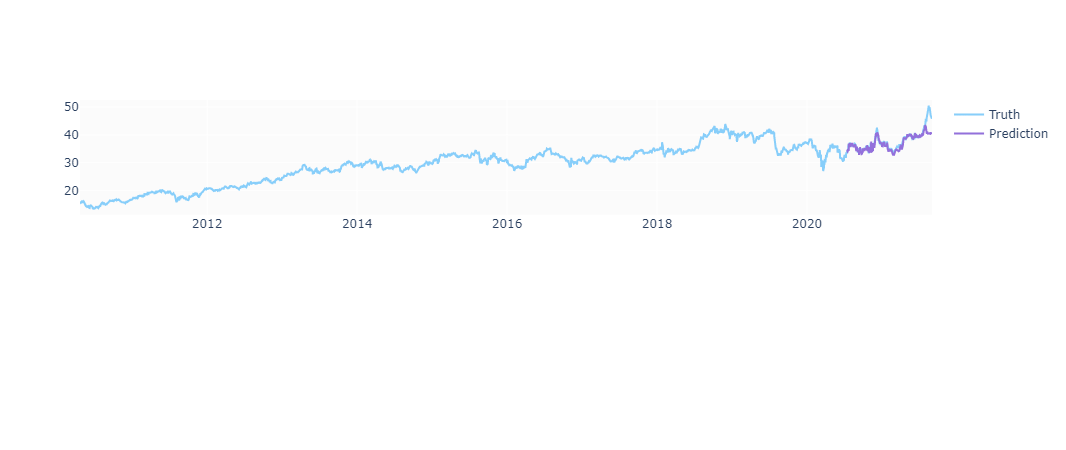

In [119]:
plot_predictions(predicted_prices, pfe_df, 'Close')